# Annotation

## Automated annotation

In [11]:
import os
import tempfile
import celltypist
from celltypist import models
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import harmonypy as hm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

data_path = "./data/"
graphics_path = "./graphics"

os.makedirs(f"{graphics_path}/Annotation", exist_ok=True)

In [2]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [12]:
data_path = "./data/"
adata_annotated = sc.read_h5ad(os.path.join(data_path, "adata_filtered.h5ad"))

In [13]:
adata_annotated

AnnData object with n_obs × n_vars = 39095 × 33538
    obs: 'sample', 'n_counts', 'n_genes', 'Patient', 'Age', 'Sampling site', 'Sex', 'Cancer stage', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'predicted_doublet', 'doublet_score', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'predicted_doublet_colors', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp

2626 highly variable genes identified.


2025-02-10 19:51:08,417 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-02-10 19:51:12,365 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-02-10 19:51:12,546 - harmonypy - INFO - Iteration 1 of 500
Iteration 1 of 500
2025-02-10 19:51:33,684 - harmonypy - INFO - Iteration 2 of 500
Iteration 2 of 500
2025-02-10 19:51:56,087 - harmonypy - INFO - Iteration 3 of 500
Iteration 3 of 500
2025-02-10 19:52:18,605 - harmonypy - INFO - Iteration 4 of 500
Iteration 4 of 500
2025-02-10 19:52:37,489 - harmonypy - INFO - Iteration 5 of 500
Iteration 5 of 500
2025-02-10 19:52:58,979 - harmonypy - INFO - Iteration 6 of 500
Iteration 6 of 500
2025-02-10 19:53:17,966 - harmonypy - INFO - Converged after 6 iterations
Converged after 6 iterations


Keys in obsm after Harmony: KeysView(AxisArrays with keys: X_pca, X_umap, X_pca_harmonize)
Shape of X_pca_harmonize: (39095, 15)


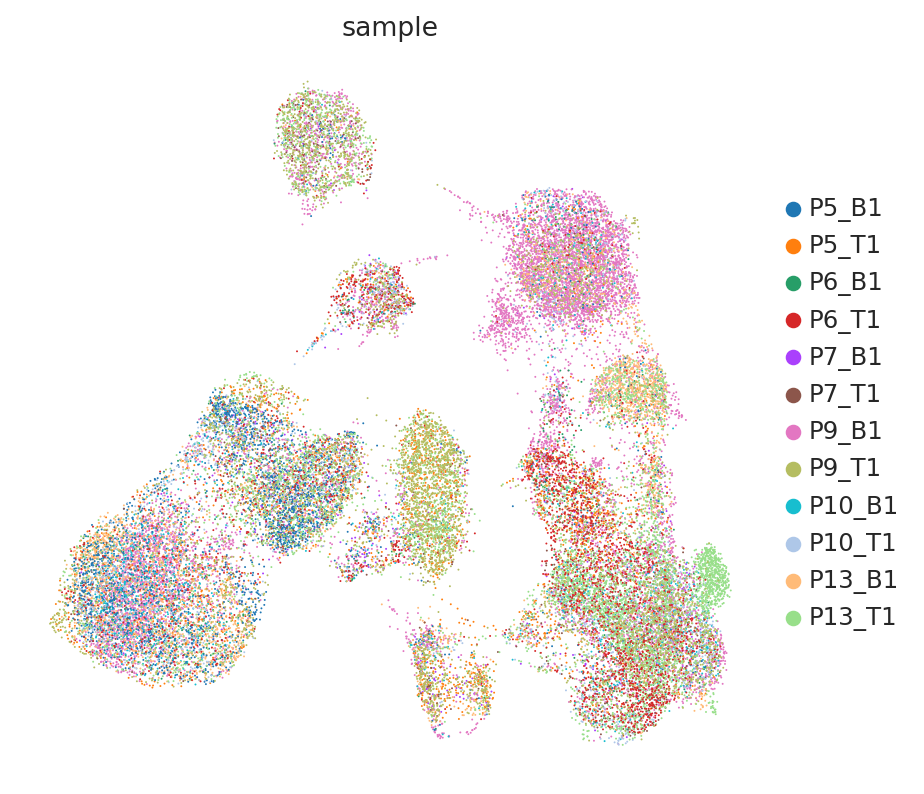

In [14]:
# Run harmony for batch correction

sc.pp.highly_variable_genes(adata_annotated, min_mean=0.00125, max_mean=3, min_disp=0.5, batch_key="sample")
print(adata_annotated.var['highly_variable'].sum(), "highly variable genes identified.")

sc.tl.pca(adata_annotated, n_comps=50, svd_solver='auto', use_highly_variable=True)

ho = hm.run_harmony(
    adata_annotated.obsm['X_pca'][:, :15],
    adata_annotated.obs,
    ["sample"],
    max_iter_kmeans=25,
    max_iter_harmony=500
)

adata_annotated.obsm["X_pca_harmonize"] = ho.Z_corr.T
print("Keys in obsm after Harmony:", adata_annotated.obsm.keys())
print("Shape of X_pca_harmonize:", adata_annotated.obsm["X_pca_harmonize"].shape)

sc.pp.neighbors(
    adata_annotated,
    n_pcs=adata_annotated.obsm["X_pca_harmonize"].shape[1],
    use_rep="X_pca_harmonize"
)

sc.tl.umap(adata_annotated)
sc.pl.umap(adata_annotated, color=["sample"])


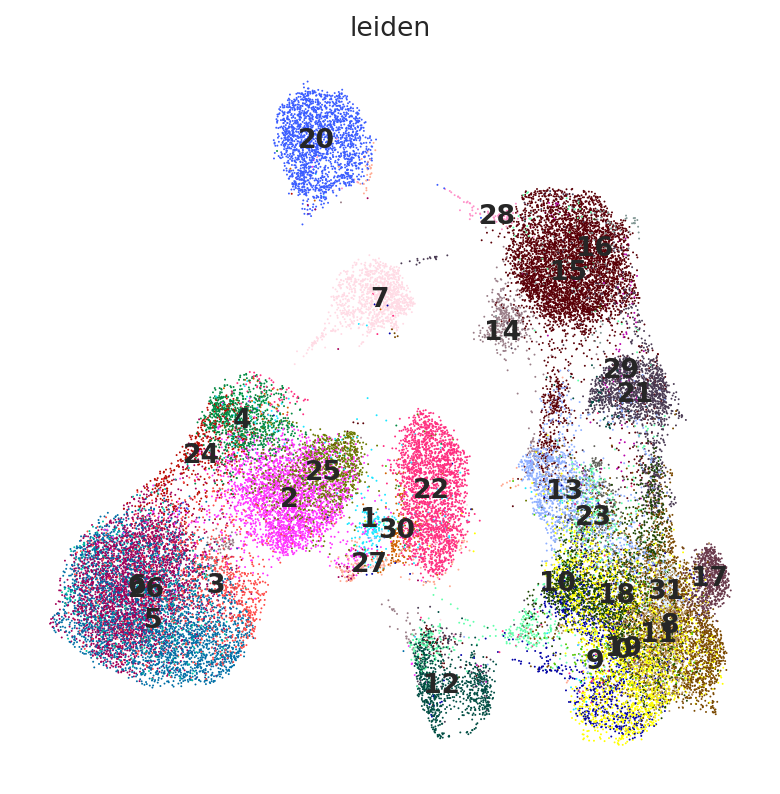

In [55]:
sc.pl.umap(adata_annotated, color=["leiden"], legend_loc="on data")

In [15]:
adata_annotated.write(os.path.join(data_path, "adata_harmonised.h5ad"))

In [16]:
# Load Human Lung Cell Atlas for reference

models.download_models(model = ['Human_Lung_Atlas.pkl', 'Cells_Lung_Airway.pkl'])
model = models.Model.load(model = 'Human_Lung_Atlas.pkl')

📂 Storing models in /home/vera/.celltypist/data/models
💾 Total models to download: 2
⏩ Skipping [1/2]: Cells_Lung_Airway.pkl (file exists)
⏩ Skipping [2/2]: Human_Lung_Atlas.pkl (file exists)


In [17]:
predictions = celltypist.annotate(adata_annotated, model = 'Human_Lung_Atlas.pkl', majority_voting = True)
adata_annotated = predictions.to_adata()

⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 39095 cells and 33538 genes
🔗 Matching reference genes in the model


🧬 4854 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


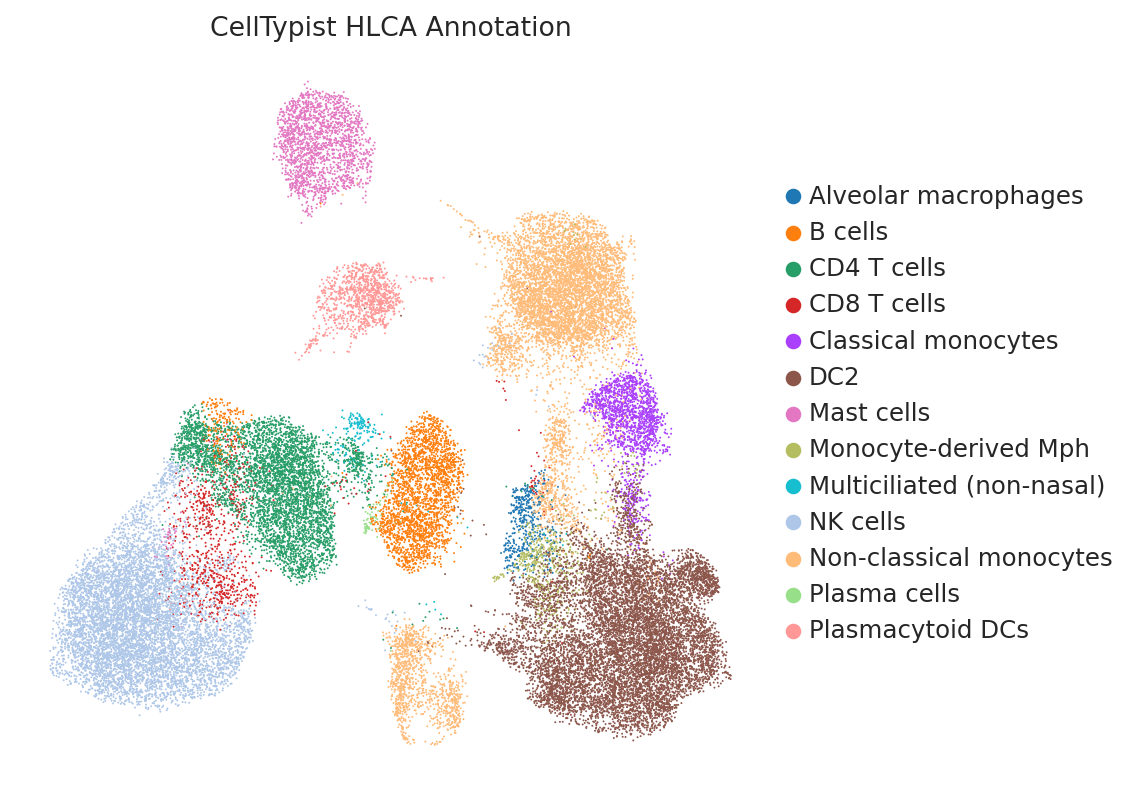

In [7]:
sc.pl.umap(adata_annotated, color = ['majority_voting'],
        title="CellTypist HLCA Annotation",
        #legend_loc = 'on data',
        )

In [18]:
adata_annotated.write(os.path.join(data_path, "adata_annotated.h5ad"))

In [ ]:
#adata_annotated = sc.read_h5ad(os.path.join(data_path, "adata_annotated.h5ad"))

## Manual Annotaion

For manual annotation, we will use table with marker genes from the Human Lung Cell Atlas (Supplementary Table 6).

The table can be dowloaded [here](https://static-content.springer.com/esm/art%3A10.1038%2Fs41591-023-02327-2/MediaObjects/41591_2023_2327_MOESM3_ESM.xlsx)

In [37]:
# Read the sheet
marker_data = pd.read_excel("41591_2023_2327_MOESM3_ESM.xlsx", sheet_name = "6 - marker genes")
marker_data = marker_data.drop(marker_data.columns[0],axis=1)
marker_data.columns = marker_data.iloc[0]
marker_data = marker_data[1:] 

cell_type_markers = {}

for col_index in range(0, marker_data.shape[1], 3):
    col_name = marker_data.columns[col_index] 
    markers = marker_data[col_name].dropna().tolist()
    cell_type_markers[col_name] = markers


with open("cell_type_markers.txt", "w") as file:
    for cell_type, markers in cell_type_markers.items():
        file.write(f"{cell_type}:\n")
        file.write(", ".join(markers) + "\n\n")

markers_from_suppl_notes = {
    "Anti-inflammatory macrophages": ["C1QB", "C1QC", "APOE", "MRC1", "MARCO"],
    "Monocyte_derived macrophages": ["CD53", "PTPRC", "CORO1A", "FCER1G", "C1orf162", "CLEC7A", "SPP1", "HAMP"],
    "STAB1+ macrophages": ["STAB1", "APOE", "C1QC", "MARCO"],
    "CAML": ["KRT18", "KRT19", "EPCAM", "LYZ", "SPI2", "CD14", "CD163", "C1QC", "APOE"],
    "Mature B cells": ["CD79A", "CD79B", "IGHM"],
    "Plasma B cells": ["JCHAIN", "IGHG1", "IGKC", "IGHA1", "XBP1", "MZB1"],
    "Mast cells": ["HDC", "MITF", "GATA2"],
    "Monocytes": ["CD14", "IL1B", "FCN1", "CXCL8", "S100A8", "S100A9"],
    "Macrophages": ["CD14", "CD163", "CD68", "MARCO", "MRC1"],
    "T cells": ["TRAC", "CD3D", "CD3E", "CD3G"],
    "Exhausted T cells": ["TIGIT", "CTLA4", "PDCD1", "LAG3", "CXCL13"],
    "Regulatory T cells": ["FOXP3", "CTLA4", "TNFRSF18"],
    "NK cells": ["NKG7", "PRF1", "GZMA", "GZMB", "GZMK", "KLRB1"],
    "Non-immune cells": ["EPCAM", "CDH1", "KRT18", "KRT19"],
}

cell_type_markers = cell_type_markers | markers_from_suppl_notes


In [ ]:
sc.tl.rank_genes_groups(adata_annotated, groupby="leiden", method="wilcoxon", key_added="rank_genes_groups_leiden")

/home/vera/miniforge3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/vera/miniforge3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/vera/miniforge3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:434: Performanc

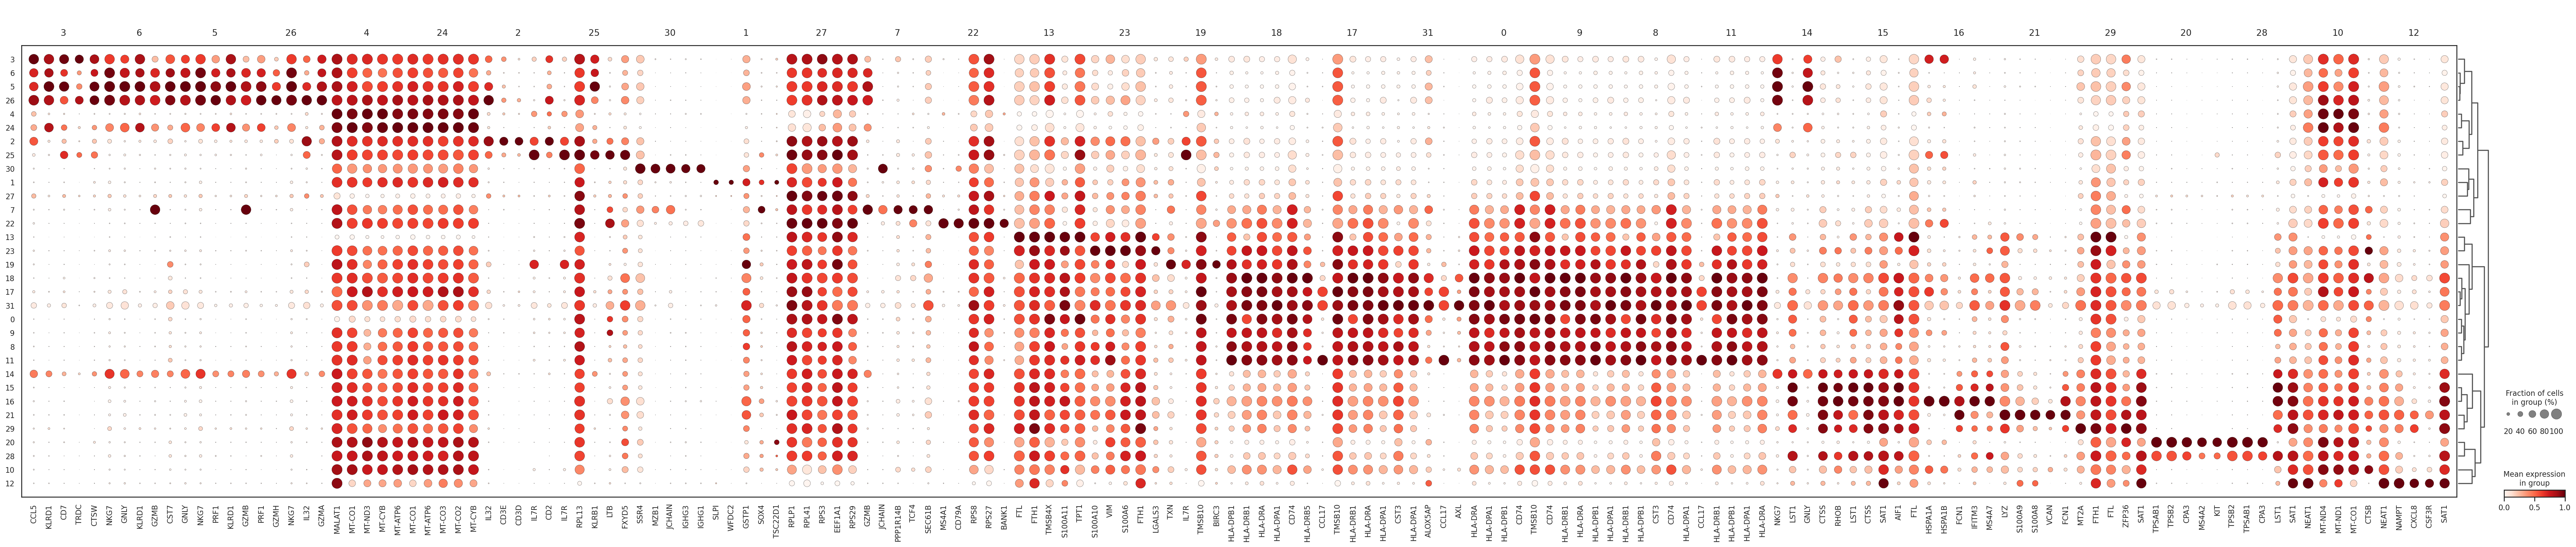

In [89]:
sns.set_theme(style="white")

sc.pl.rank_genes_groups_dotplot(
    adata_annotated,
    groupby="leiden",
    standard_scale="var",
    n_genes=5,
    key="rank_genes_groups_leiden",
    #gene_symbols="gene_names",
    )


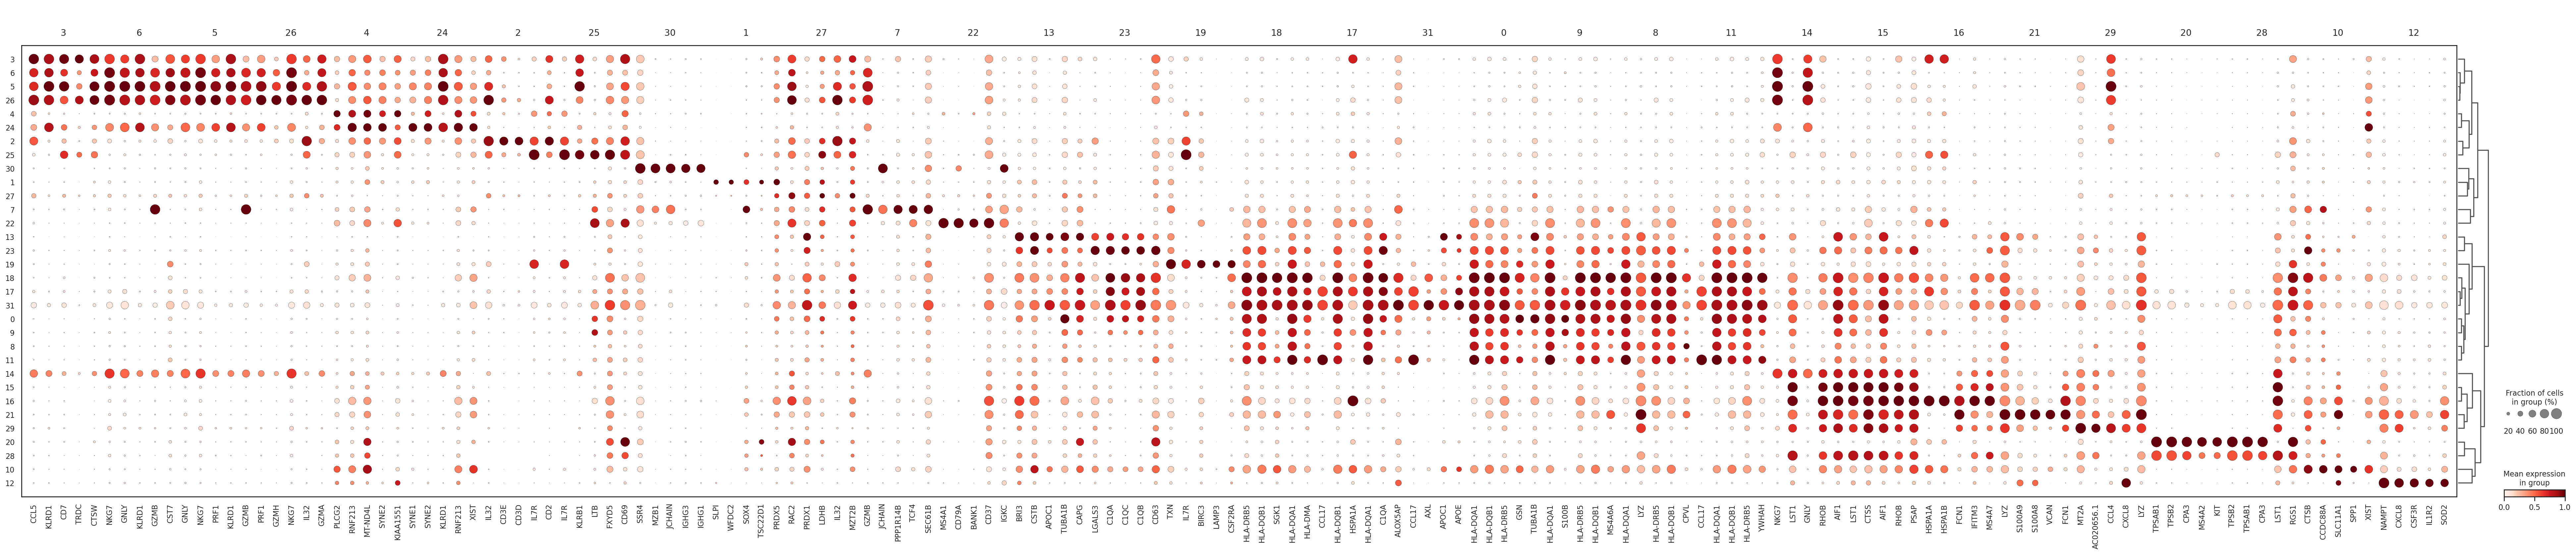

In [90]:

sc.tl.filter_rank_genes_groups(
    adata_annotated,
    min_in_group_fraction=0.3,
    key="rank_genes_groups_leiden",
    key_added="rank_genes_groups_leiden_filtered"
)


fig = sc.pl.rank_genes_groups_dotplot(
    adata_annotated,
    groupby="leiden",
    standard_scale="var",
    n_genes=5,
    key="rank_genes_groups_leiden_filtered",
    #gene_symbols="gene_names",
    return_fig=True)

output_path = os.path.join(graphics_path, "Annotation", "rank_genes_for_clusters.pdf")
fig.savefig(output_path)


In [24]:
# Extract top genes for each cluster from the figure

ranked_genes = adata_annotated.uns['rank_genes_groups_leiden_filtered']

top_genes_by_cluster = {}

for cluster in ranked_genes['names'].dtype.names:
    top_genes = [gene for gene in ranked_genes['names'][cluster] if pd.notna(gene)][:20]
    #gene_symbols = [
    #    adata_annotated.var.loc[gene, 'gene_names'] if gene in adata_annotated.var.index else gene 
    #    for gene in top_genes
    #]
    top_genes_by_cluster[cluster] = top_genes

for cluster, genes in top_genes_by_cluster.items():
    print(f"Cluster {cluster}: {genes}")

Cluster 0: ['HLA-DQA1', 'HLA-DQB1', 'HLA-DRB5', 'GSN', 'TUBA1B', 'S100B', 'YWHAH', 'MS4A6A', 'AIF1', 'PPA1', 'PKIB', 'HLA-DQB2', 'COTL1', 'C1QC', 'C1QA', 'ALDH2', 'SPI1', 'CTSH', 'RGS10', 'HLA-DMA']
Cluster 1: ['SLPI', 'WFDC2', 'SOX4', 'TSC22D1', 'PRDX5', 'NUCB2', 'DSTN', 'SPINT2', 'TXN', 'HOPX', 'DYNLL1', 'YWHAE', 'EZR', 'HMGN3', 'GTF2I', 'LDHB', 'SELENOW', 'HSPB1', 'UFC1']
Cluster 2: ['IL32', 'CD3E', 'CD3D', 'IL7R', 'CD2', 'CD3G', 'TRAC', 'TRBC2', 'CD69', 'CCL5', 'PRDM1', 'ETS1', 'BATF', 'TUBA4A', 'CD96', 'GPR171', 'RBPJ', 'RNF19A', 'PIK3IP1', 'SARAF']
Cluster 3: ['CCL5', 'KLRD1', 'CD7', 'TRDC', 'CTSW', 'HSPA1B', 'XCL2', 'HSPA1A', 'DUSP2', 'GZMA', 'PIK3R1', 'CD247', 'NKG7', 'CD69', 'DNAJB1', 'GZMK', 'APOBEC3G', 'HCST', 'STK17A', 'EVL']
Cluster 4: ['PLCG2', 'RNF213', 'MT-ND4L', 'SYNE2', 'KIAA1551', 'NKTR', 'DDX17', 'ARGLU1', 'EML4', 'SMCHD1', 'ETS1', 'RNF19A', 'IL7R', 'GOLGA8B', 'SLC4A7', 'AKAP9', 'ANKRD36C', 'LUC7L3', 'MACF1', 'ANKRD11']
Cluster 5: ['GNLY', 'NKG7', 'PRF1', 'KLRD1', '

In [46]:
# Compare genes from clusters with cell type signatures from reference

results = []

for cluster_name, expressed_genes in top_genes_by_cluster.items():
    best_match = None
    max_hits = 0
    overlapping_genes = []

    for cell_type, signature_genes in cell_type_markers.items():
        intersection = set(expressed_genes) & set(signature_genes)
        num_hits = len(intersection)

        if num_hits > max_hits:
            best_match = cell_type
            max_hits = num_hits
            overlapping_genes = list(intersection)

    results.append({
        "Cluster": cluster_name,
        "Top_cell_type": best_match,
        "Hits": max_hits,
        "Matching_genes": overlapping_genes
    })

results_df = pd.DataFrame(results)

... storing 'manual_annotation' as categorical


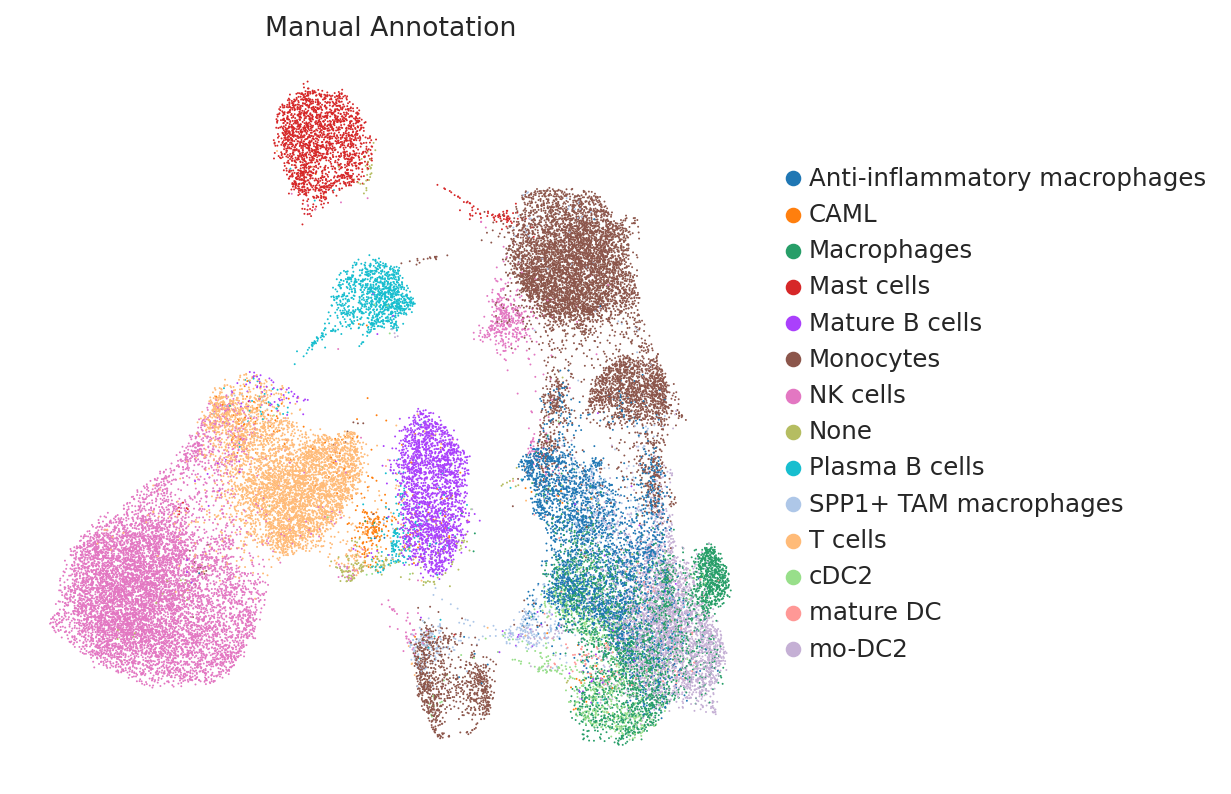

In [84]:
merging_dict = {
    "0": "Macrophages",
    "1": "CAML",
    "2": "T cells",
    "3": "NK cells",
    "4": "T cells",
    "5": "NK cells",
    "6": "NK cells",
    "7": "Plasma B cells",
    "8": "mo-DC2",
    "9": "cDC2",
    "10": "SPP1+ TAM macrophages",
    "11": "mo-DC2",
    "12": "Monocytes",
    "13": "Anti-inflammatory macrophages",
    "14": "NK cells",
    "15": "Monocytes",
    "16": "Monocytes",
    "17": "Macrophages",
    "18": "Anti-inflammatory macrophages",
    "19": "mature DC",
    "20": "Mast cells",
    "21": "Monocytes",
    "22": "Mature B cells",
    "23": "Anti-inflammatory macrophages",
    "24": "NK cells",
    "25": "T cells",
    "26": "NK cells",
    "27": "None",
    "28": "Mast cells",
    "29": "Monocytes",
    "30": "Plasma B cells",
    "31": "Macrophages"
}



adata_annotated.obs["manual_annotation"] = adata_annotated.obs["leiden"].map(merging_dict)

sc.pl.umap(adata_annotated, color="manual_annotation", title = "Manual Annotation")

In [148]:
del adata_annotated.uns["rank_genes_groups_leiden_filtered"]
adata_annotated.write(os.path.join(data_path, "adata_annotated_full.h5ad"))

... storing 'Patient' as categorical


In [ ]:
#adata_annotated = sc.read(os.path.join(data_path, "adata_annotated_full.h5ad"))

<Figure size 800x640 with 0 Axes>

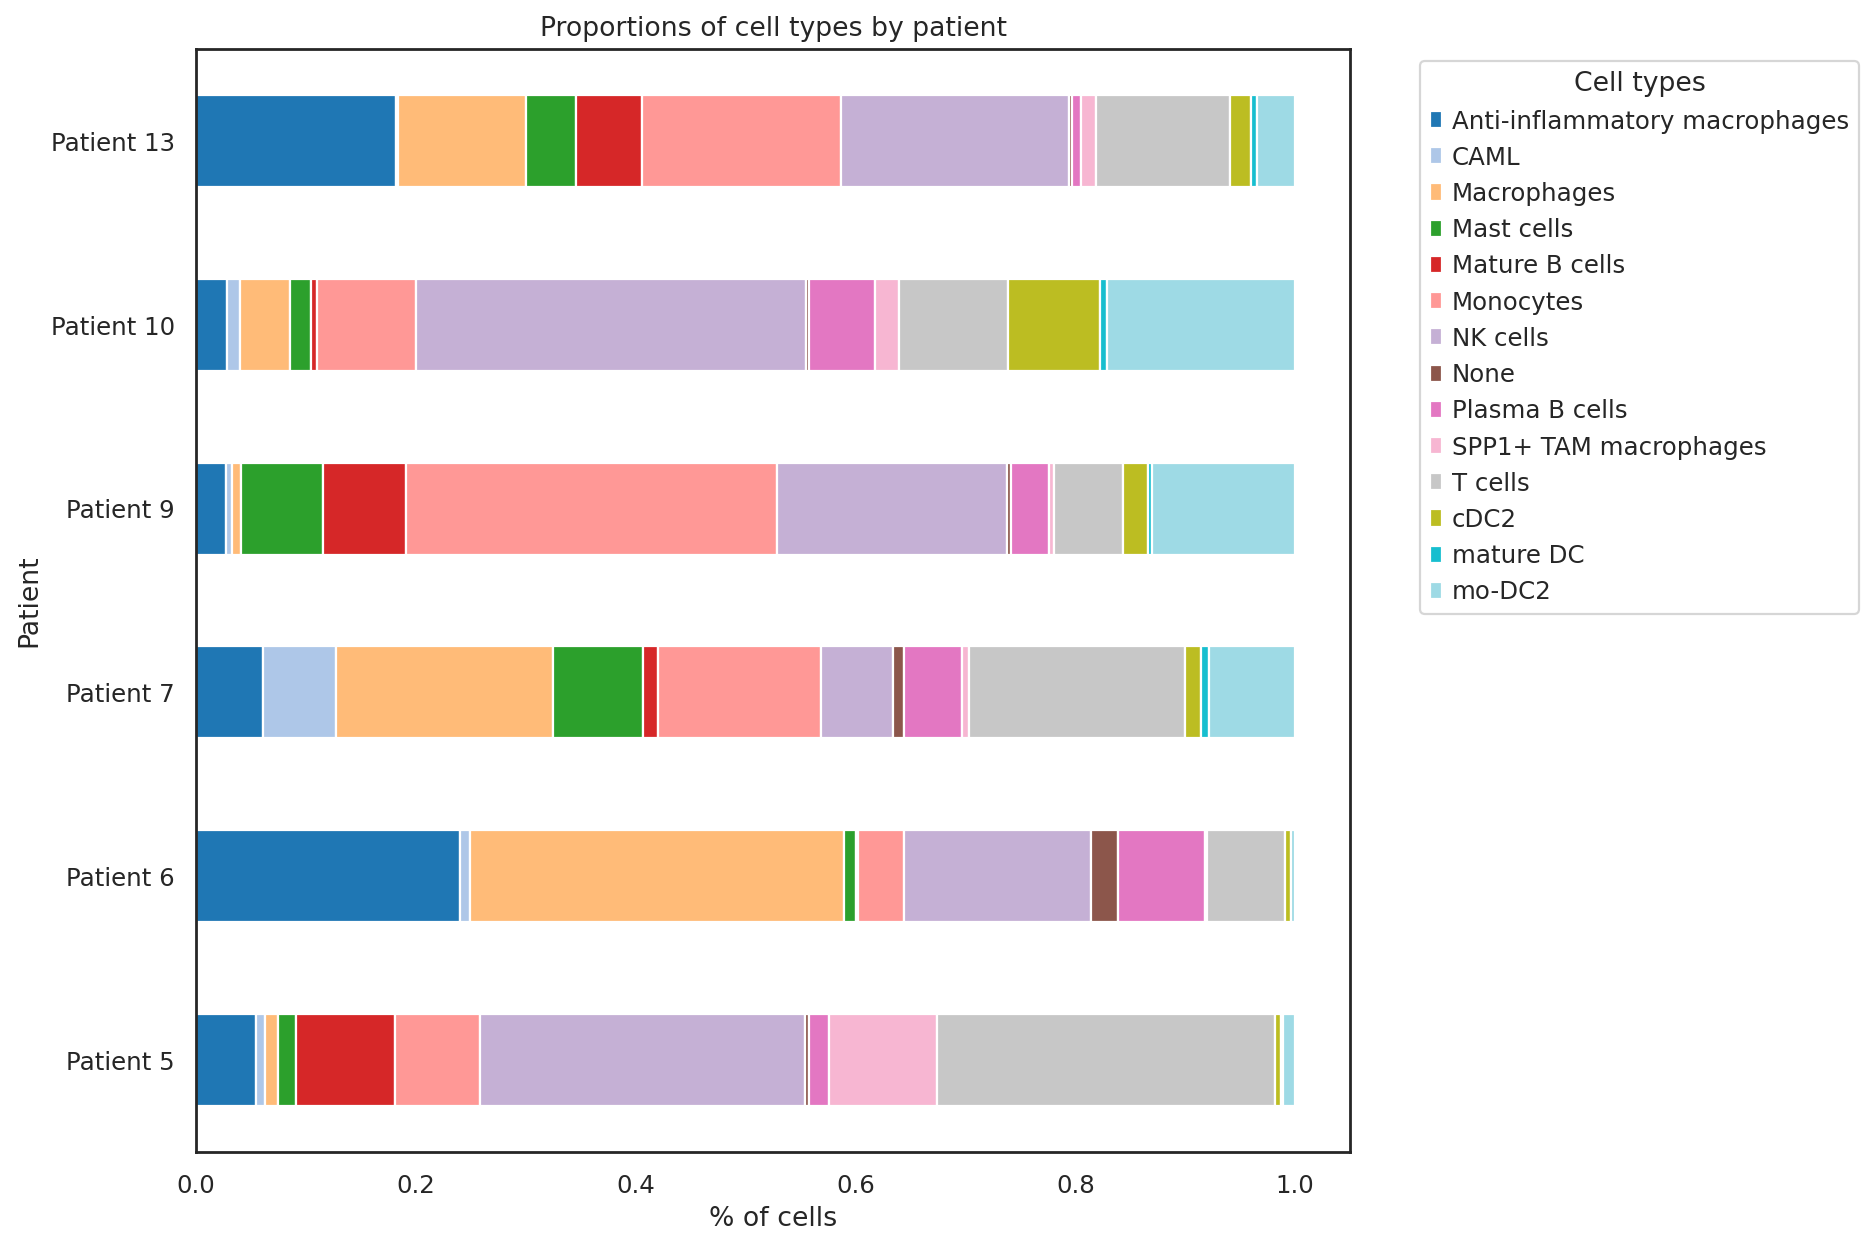

In [102]:
# Calculate cluster proportions per patient

cell_type_counts = adata_annotated.obs.groupby(["Patient", "manual_annotation"]).size().unstack(fill_value=0)

cell_type_proportions = cell_type_counts.div(cell_type_counts.sum(axis=1), axis=0)

plt.figure(figsize=(10, 8))
cell_type_proportions.plot(kind="barh", stacked=True, figsize=(12, 8), cmap="tab20")

plt.xlabel("% of cells")
plt.ylabel("Patient")
plt.title("Proportions of cell types by patient")
plt.legend(title="Cell types", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()